In [25]:
its_jupyter_notebook = True

import pandas as pd
import os
import time
import numpy as np
import seaborn as sns
import pickle
import torch
from tqdm.notebook import tqdm
from pathlib import Path
import argparse
import math
from scipy import stats
import copy
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

sys.path.insert(0, '..')

from util.evaluation import load_paris_results, load_ricseq_splash_mario_results, map_signal_to_sigmoid_range, balance_df, plot_histogram_01, remove_outliers, log_func, load_res_and_tools, plot_all_model_auc, plot_all_model_auc, obtain_all_model_auc, obtain_all_model_auc_patches, obtain_subset_from_task, plot_results_of_all_models, obtain_sr_nosr, make_plot_kde_and_test_difference, calculate_correlations
from util.plot_utils import plot_results_based_on_treshold_for_all_models, plot_results_based_on_topbottom_for_all_models, plot_results_how_many_repeats_in_pred_pos_for_all_models, plot_metric_confidence_for_all_models, plot_tnr_based_on_distance_for_all_models, plot_confidence_based_on_distance_for_all_models, plot_tnr_for_all_models, quantile_bins, plot_features_vs_risearch2_confidence, plot_heatmap
# %load_ext autoreload
# %autoreload 2
from run_compare_models import load_results_new
from config import *
from models.nt_classifier import build as build_model 
from util.evaluation import *
if its_jupyter_notebook:
    sys.argv = [''] #Remove this if it's not a jupyter notebook!
    
external_dataset_dir = os.path.join(dataset_files_dir, 'external_dataset', '500_test_tables')

In [26]:
checkpoint_dir_paths = []

chkpt_folder = os.path.join(ROOT_DIR, 'checkpoints')

models_to_check = os.listdir(chkpt_folder)
for model_name in models_to_check:
    model_folder = os.path.join(chkpt_folder, model_name)
    test_paris = os.path.join(chkpt_folder, model_name, 'test_results500.csv')
    ricseq = os.path.join(chkpt_folder, model_name, 'ricseq_results500.csv')
    splash = os.path.join(chkpt_folder, model_name, 'splash_results500.csv')

    testENHN_paris = os.path.join(chkpt_folder, model_name, 'testENHN_results500.csv')
    ricseqENHN = os.path.join(chkpt_folder, model_name, 'ricseqENHN_results500.csv')
    splashENHN = os.path.join(chkpt_folder, model_name, 'splashENHN_results500.csv')
    if os.path.exists(test_paris) & os.path.exists(ricseq) & os.path.exists(splash) & os.path.exists(testENHN_paris) & os.path.exists(ricseqENHN) & os.path.exists(splashENHN) :
        checkpoint_dir_paths.append(model_folder)

In [27]:
for i in range(1, 2):
    df, name_map = load_results_new(checkpoint_dir_paths[:i], chkpt_folder)

In [28]:
n_top = 8
rank_based_column = f'prec_interactors_5_ricseq' #'auc_EPSN_ricseq'


min_tnr_ricseq = 72
min_tnr_psoralen = 72

subset = df[(df['tnr_enhn500_ricseq'] > min_tnr_ricseq) & (df['tnr_enhn500_psoralen'] > min_tnr_psoralen)].reset_index(drop = True)

monot_cond_ricseq_patch = (subset.prec_patches_5_ricseq >= subset.prec_patches_52_ricseq) & (subset.prec_patches_52_ricseq >= subset.prec_patches_100_ricseq)
monot_cond_ricseq_int = (subset.prec_interactors_5_ricseq >= subset.prec_interactors_52_ricseq) & (subset.prec_interactors_52_ricseq >= subset.prec_interactors_100_ricseq)
monot_cond_psoralen_patch = (subset.prec_patches_5_psoralen >= subset.prec_patches_52_psoralen) & (subset.prec_patches_52_psoralen >= subset.prec_patches_100_psoralen)
monot_cond_psoralen_int = (subset.prec_interactors_5_psoralen >= subset.prec_interactors_52_psoralen) & (subset.prec_interactors_52_psoralen >= subset.prec_interactors_100_psoralen)
subset = subset[monot_cond_ricseq_patch&monot_cond_ricseq_int&monot_cond_psoralen_patch&monot_cond_psoralen_int].reset_index(drop = True)


monot_cond_ricseq_patch_npv = (subset.npv_patches_5_ricseq >= subset.npv_patches_52_ricseq) & (subset.npv_patches_52_ricseq >= subset.npv_patches_100_ricseq)
monot_cond_ricseq_int_npv = (subset.npv_interactors_5_ricseq >= subset.npv_interactors_52_ricseq) & (subset.npv_interactors_52_ricseq >= subset.npv_interactors_100_ricseq)
monot_cond_psoralen_patch_npv = (subset.npv_patches_5_psoralen >= subset.npv_patches_52_psoralen) & (subset.npv_patches_52_psoralen >= subset.npv_patches_100_psoralen)
monot_cond_psoralen_int_npv = (subset.npv_interactors_5_psoralen >= subset.npv_interactors_52_psoralen) & (subset.npv_interactors_52_psoralen >= subset.npv_interactors_100_psoralen)
subset = subset[monot_cond_ricseq_patch_npv&monot_cond_ricseq_int_npv&monot_cond_psoralen_patch_npv&monot_cond_psoralen_int_npv].reset_index(drop = True)


subset = subset[
    (subset.auc_interactors_ricseq_nread7>=subset.auc_interactors_ricseq_nread2) &
    (subset.auc_patches_ricseq_nread7>=subset.auc_patches_ricseq_nread2)
].reset_index(drop = True)

subset = subset[(subset.auc_EPSN_ricseq>=0.54)].reset_index(drop = True) #risearch2 is 0.54

subset = subset.sort_values(rank_based_column, ascending = False).head(n_top).reset_index(drop = True)

In [39]:
best_models = []
for i in name_map.keys():
    if name_map[i] in ['/data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_PARISFINETUNINGtrainhqRICSEQval0055_NOWENHNokSN_parisfinetuningTRAINHQhumanRICSEQval0084',
             '/data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_splashPARISFINETUNINGtrainhqRICSEQval0060_NOWENHNokSN_splashPARISFINETUNINGtrainhqRICSEQval0083',
             '/data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_PARISFINETUNINGtrainhqRICSEQval0055_NOWENHNokSN_parisfinetuningTRAINHQhumanRICSEQval0079', 
             '/data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039_NOWENHNokSN_PARISFINETUNINGtrainhqSPLASHval0043',
             '/data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_splashPARISFINETUNINGtrainhqRICSEQval0060_NOWENHNokSN_splashPARISFINETUNINGtrainhqRICSEQval0064',
             '/data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_NOWENHNokSN_splashPARISFINETUNINGtrainhqRICSEQval0063',
             '/data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_PARISFINETUNINGtrainhqRICSEQval0055_NOWENHNokSN_parisfinetuningTRAINHQhumanRICSEQval0059',
             '/data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_PARISFINETUNINGtrainhqRICSEQval0059_NOWENHNokSN_SPLASHparisfinetuningTRAINHQhumanRICSEQval0064'
            ]:
        best_models.append(i)
        
subset = df[df.model.isin(best_models)].reset_index(drop = True)

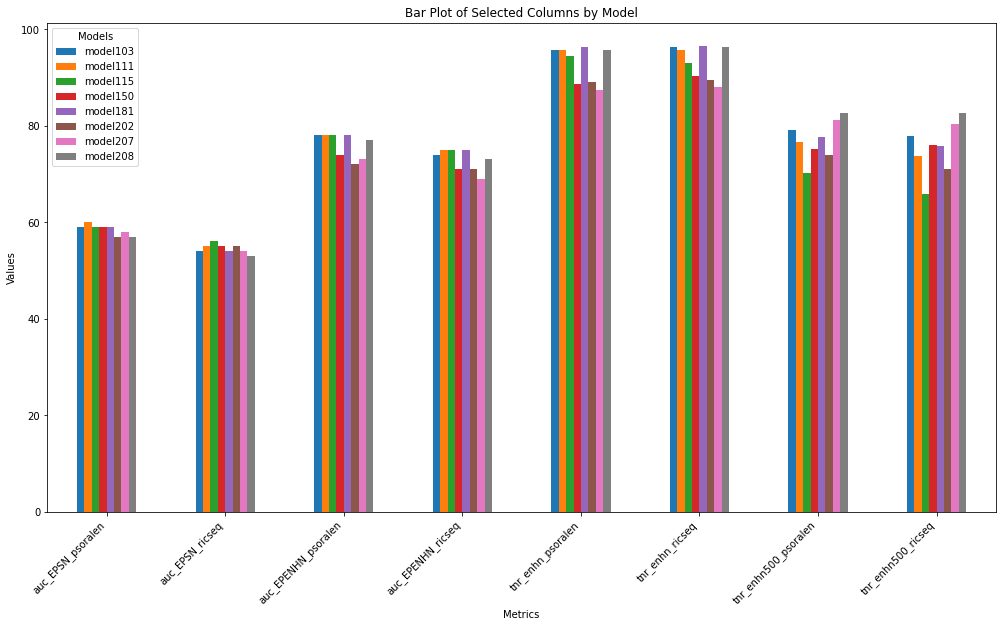

In [40]:
figsize = (17, 9)
bar_width = 0.5

tnrs = []
columns = ['auc_EPSN_psoralen',  'auc_EPSN_ricseq', 'auc_EPENHN_psoralen', 'auc_EPENHN_ricseq', 'tnr_enhn_psoralen', 'tnr_enhn_ricseq', 'tnr_enhn500_psoralen', 'tnr_enhn500_ricseq']


# Transposing the dataframe to have columns as the x-axis
subset_transposed = subset.filter(['model'] + columns,axis = 1).set_index('model').transpose()

# Creating the bar plot with columns on the x-axis
subset_transposed.plot(kind='bar', figsize=figsize)
plt.title('Bar Plot of Selected Columns by Model')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Models')
plt.show()

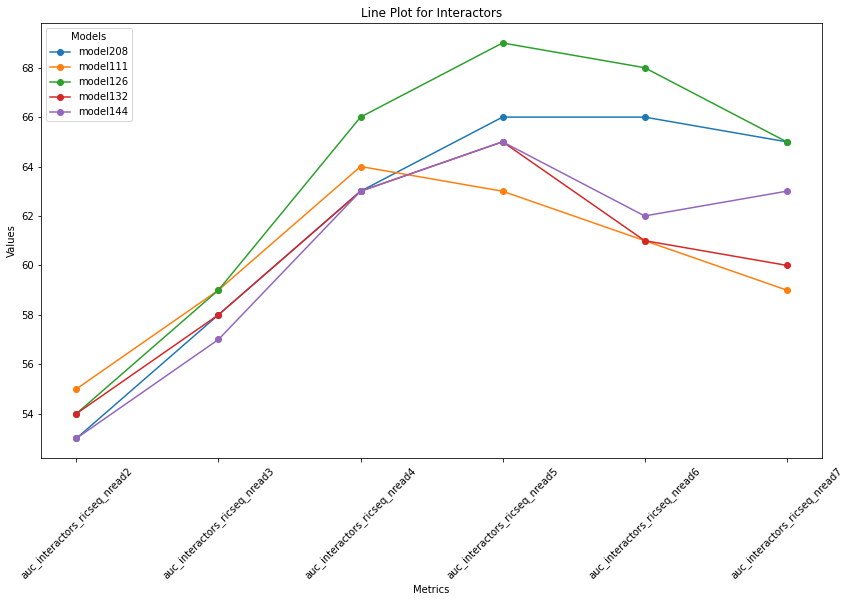

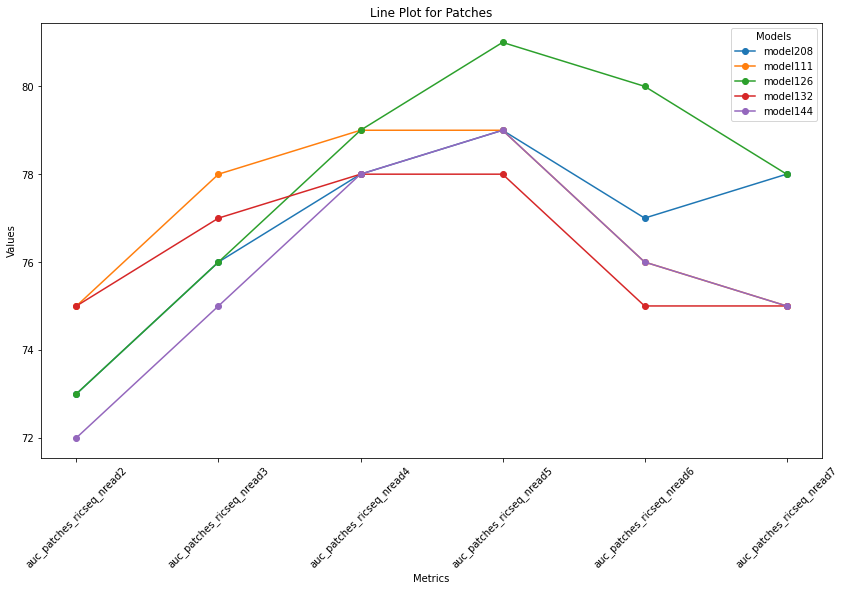

In [21]:
# Selecting the columns for the interactors and patches
interactors_columns = [
    'auc_interactors_ricseq_nread2', 'auc_interactors_ricseq_nread3', 'auc_interactors_ricseq_nread4',
    'auc_interactors_ricseq_nread5', 'auc_interactors_ricseq_nread6', 'auc_interactors_ricseq_nread7'
]
patches_columns = [
    'auc_patches_ricseq_nread2', 'auc_patches_ricseq_nread3', 'auc_patches_ricseq_nread4',
    'auc_patches_ricseq_nread5', 'auc_patches_ricseq_nread6', 'auc_patches_ricseq_nread7'
]

# Plotting the line plot for interactors
plt.figure(figsize=(14, 8))
for model in subset['model']:
    plt.plot(interactors_columns, subset[subset['model'] == model][interactors_columns].values.flatten(), marker='o', label=model)
plt.title('Line Plot for Interactors')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend(title='Models')
plt.show()

# Plotting the line plot for patches
plt.figure(figsize=(14, 8))
for model in subset['model']:
    plt.plot(patches_columns, subset[subset['model'] == model][patches_columns].values.flatten(), marker='o', label=model)
plt.title('Line Plot for Patches')
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.xticks(rotation=45)
plt.legend(title='Models')
plt.show()

In [22]:
from util.plot_utils import collect_results_based_on_topbottom_for_all_models
from mpl_toolkits.axes_grid1 import make_axes_locatable

def npv_precision(precision_data, npv_data, model_names, figsize):
    assert precision_data.shape == npv_data.shape
    
    num_modelli, n_points =  precision_data.shape[0], precision_data.shape[1]
    
    percentuali_neg = np.linspace(1, 100, num=n_points).astype(int)
    percentuali_pos = np.linspace(1, 100, num=n_points).astype(int)[::-1]

    percentuali = np.concatenate((percentuali_neg, percentuali_pos))
    
    # Unione dei dati di precisione e NPV in un unico array per l'asse Y
    combined_data = np.hstack((npv_data, precision_data))

    # Creiamo un array per la combinazione delle due colormap
    combined_image = np.zeros((num_modelli, 2*n_points, 3))

    # Applichiamo la colormap 'Oranges' alla parte sinistra (NPV)
    norm = plt.Normalize(vmin=0, vmax=1)
    npv_colored = plt.cm.Oranges(norm(npv_data))[:, :, :3]  # Consideriamo solo i primi tre canali (RGB)
    combined_image[:, :n_points, :] = npv_colored

    # Applichiamo la colormap 'Blues' alla parte destra (Precision)
    precision_colored = plt.cm.Blues(norm(precision_data))[:, :, :3]  # Consideriamo solo i primi tre canali (RGB)
    combined_image[:, n_points:, :] = precision_colored

    # Plotting
    fig, ax = plt.subplots(figsize=figsize)

    # Creiamo il grafico principale
    im = ax.imshow(combined_image, aspect='auto', interpolation='nearest')
    plt.xlabel('Percentage of bottom / top predictions (%)')
    plt.ylabel('Model')
    plt.axvline(x=n_points-0.5, color='black', linestyle='--', label='Threshold between positive and negative predictions')
    plt.title('NPV over bottom predictions (left), Precision over top predictions (right)')
    plt.xticks(np.arange(len(percentuali)), percentuali)
    plt.yticks(np.arange(num_modelli), model_names)

    # Divider per le due colorbar
    divider = make_axes_locatable(ax)
    cax1 = divider.append_axes("right", size="5%", pad=0.1)
    cax2 = divider.append_axes("right", size="5%", pad=0.7)

    # Colorbar per NPV
    cb1 = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Oranges'), cax=cax1)
    cb1.set_label('NPV Score')

    # Colorbar per Precision
    cb2 = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='Blues'), cax=cax2)
    cb2.set_label('Precision Score')

    # Aggiungiamo i numeri alle celle del grafico
    for i in range(num_modelli):
        for j in range(n_points):
            text = ax.text(j, i, f"{npv_data[i, j]:.2f}", ha="center", va="center", color="white", fontweight='bold')
            text = ax.text(j + n_points, i, f"{precision_data[i, j]:.2f}", ha="center", va="center", color="white", fontweight='bold')

    plt.legend()

    plt.tight_layout()
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


psoralen interactors


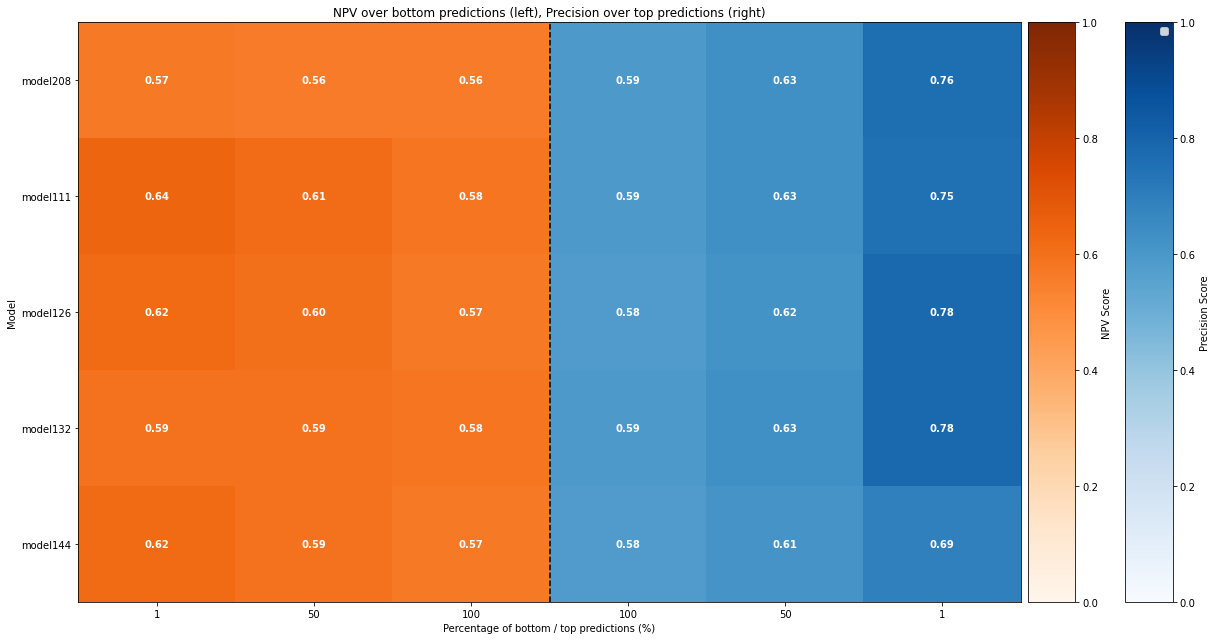

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ricseq interactors


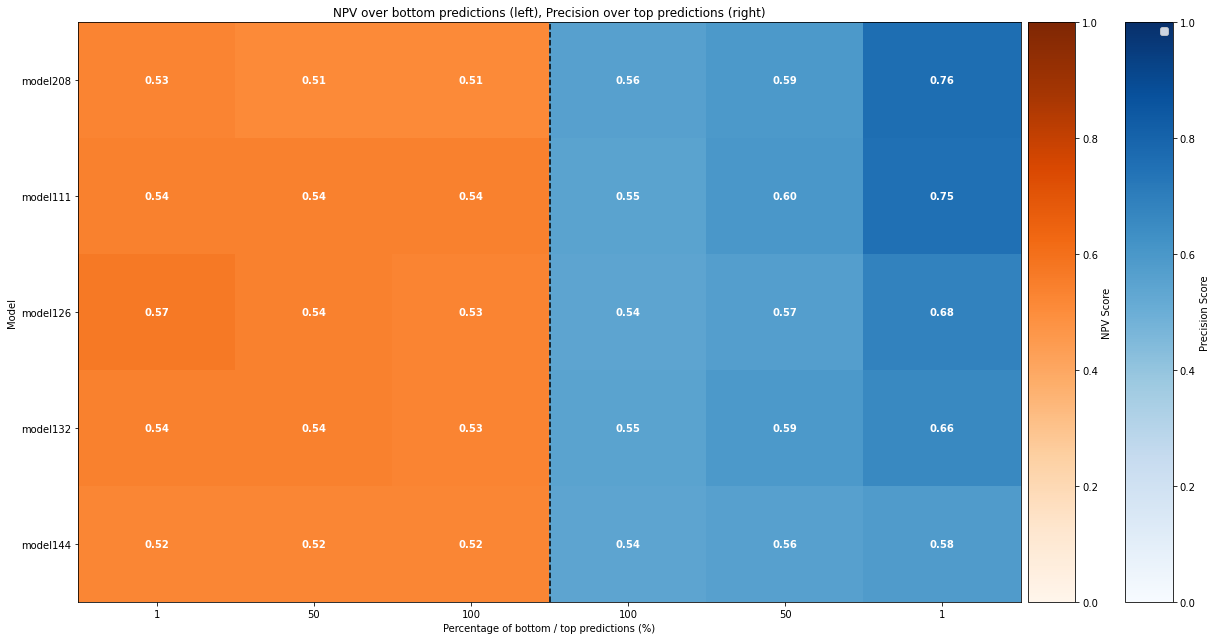

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


psoralen patches


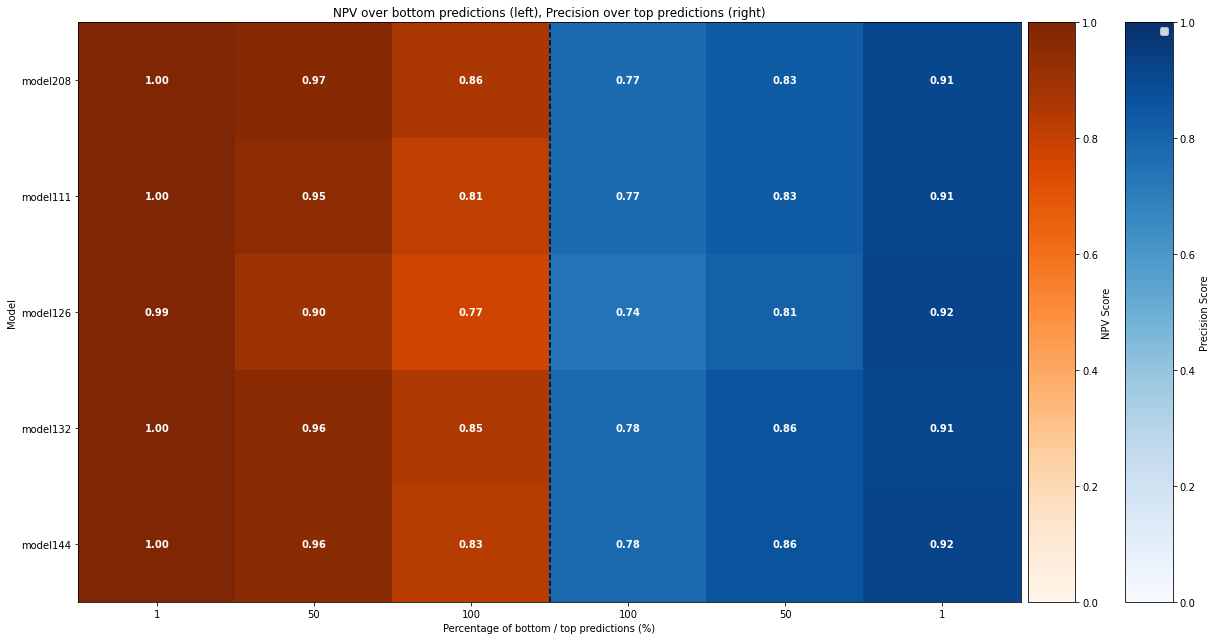

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


ricseq patches


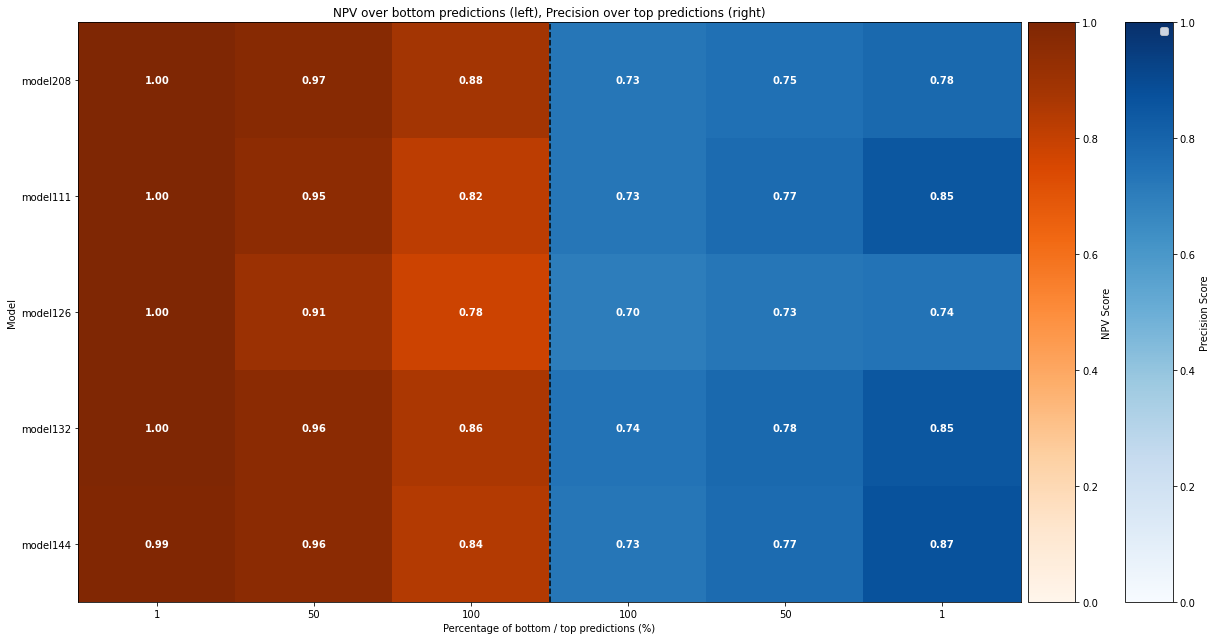

In [23]:
for task in ['interactors', 'patches']:
    
    for dataset in ['psoralen', 'ricseq']:

        print(dataset, task)
        precision_data = np.array([subset[f'prec_{task}_{str(i)}_{dataset}'] for i in [100, 52, 5]]).T
        npv_models = np.array([subset[f'npv_{task}_{str(i)}_{dataset}'] for i in [100, 52, 5]]).T
        npv_data = np.array([npv [::-1] for npv in npv_models])
        npv_precision(precision_data/100, npv_data/100, list(subset['model']), figsize)

In [24]:
for _, i in subset.iterrows():
    print(i.model, '\t', name_map[i.model])

model208 	 /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_PARISFINETUNINGtrainhqRICSEQval0055_NOWENHNokSN_parisfinetuningTRAINHQhumanRICSEQval0084
model111 	 /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039parisHQSPLASHval0054_okSN_splashPARISFINETUNINGtrainhqRICSEQval0060_NOWENHNokSN_splashPARISFINETUNINGtrainhqRICSEQval0064
model126 	 /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_wrongSN_easypretrain11_paristfinetuningsplashRICSEQval0031_NOWENHNokSN_PARISFINETUNINGtrainhqSPLASHval0068
model132 	 /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_wrongSN_easypretrain11_paristfinetuningSPLASHval0039_NOWENHNokSN_splashPARISFINETUNINGtrainhqRICSEQval0054
model144 	 /data01/giorgio/RNARNA-NT/checkpoints/all_modelarch2_wrongSN_easypretrain11_NOWENHNokSN_splashPARISFINETUNINGtrainhqRICSEQval0026


In [10]:
row = df.iloc[0]
for i in range(len(row)):
    print(list(row.index)[i], '\t', row[i])

model 	 model0
auc_EPSN_psoralen 	 59.0
auc_EPENHN_psoralen 	 70.0
auc_EPSN_ricseq 	 54.0
auc_EPENHN_ricseq 	 68.0
auc_EPSN_mario 	 49.0
auc_EPENHN_mario 	 63.0
tnr_enhn_psoralen 	 84.12
tnr_enhn500_psoralen 	 69.13
tnr_enhn_ricseq 	 86.89
tnr_enhn500_ricseq 	 68.36
tnr_enhn_mario 	 78.47
tnr_enhn500_mario 	 55.36
prec_interactors_100_psoralen 	 58.0
npv_interactors_100_psoralen 	 57.0
prec_interactors_52_psoralen 	 63.0
npv_interactors_52_psoralen 	 59.0
prec_interactors_5_psoralen 	 77.0
npv_interactors_5_psoralen 	 57.0
prec_patches_100_psoralen 	 67.0
npv_patches_100_psoralen 	 71.0
prec_patches_52_psoralen 	 71.0
npv_patches_52_psoralen 	 83.0
prec_patches_5_psoralen 	 69.0
npv_patches_5_psoralen 	 98.0
prec_interactors_100_ricseq 	 54.0
npv_interactors_100_ricseq 	 53.0
prec_interactors_52_ricseq 	 57.0
npv_interactors_52_ricseq 	 53.0
prec_interactors_5_ricseq 	 70.0
npv_interactors_5_ricseq 	 56.0
prec_patches_100_ricseq 	 65.0
npv_patches_100_ricseq 	 72.0
prec_patches_52_rics